# Model Exploration

## Import Packages

In [237]:
# Tooling
import os
import glob
import pickle
from colorama import Fore, Style
from typing import Tuple

# Data Exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Household Package Imports
from household_package.clean import clean_data
from household_package.data import call_data_cloud

# Models
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import Model, Sequential, layers, regularizers, optimizers
from keras.callbacks import EarlyStopping


## Import Data From Cloud

In [76]:
df = call_data_cloud()


In [77]:
df.shape


(18496, 34)

In [78]:
df.head()


,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,NCOMBATH,NHAFBATH,TOTROOMS,WALLTYPE,...,NUMPORTEL,AIRCOND,LGTIN1TO4,LGTIN4TO8,LGTINMORE8,SMARTMETER,SOLAR,NHSLDMEM,SQFTEST,KWH
0,WEST,New Mexico,Mixed-Dry,2,1,4,3,0,8,1,...,-2,1,6,8,3,0,0,2,2100,12521.48
1,SOUTH,Texas,Hot-Dry,2,1,8,3,0,9,2,...,-2,1,4,5,2,0,0,5,3080,9657.64
2,SOUTH,Arkansas,Mixed-Humid,3,1,4,1,0,4,6,...,-2,1,3,15,3,-4,0,3,990,9972.38
3,SOUTH,Oklahoma,Mixed-Humid,2,1,2,2,0,7,1,...,-2,1,8,5,6,-4,0,2,1600,8167.71
4,SOUTH,Maryland,Mixed-Humid,3,2,1,3,1,5,1,...,1,1,23,10,12,-4,0,2,1400,7159.45


## Method 1 - Perform Own Preprocessing

In [250]:
from google.cloud import bigquery

PROJECT = "wagon-bootcamp-401514"
DATASET = "01_household_energy"
TABLE = "recs2020"
#MY_PROJECT = "melodic-arcadia-401515"
LOCATION = "EU"


query = f"""
    SELECT *
    FROM `{PROJECT}.{DATASET}.{TABLE}`
    """

client = bigquery.Client()
query_job = client.query(query)
result = query_job.result()
df_raw = result.to_dataframe()


### Test Explode

In [280]:
test_explode = feature_mapping[feature_mapping["Response Codes"].str.contains('\n')]

# filtered_df = df[df['column_name'].str.contains('\n')]

test_explode_exploded = test_explode.assign(response_code=test_explode['Response Codes'].str.split('\n')).explode('Response Codes')
# test_explode_exploded = test_explode_exploded[[]]

test_explode_exploded = test_explode_exploded[["Variable","response_code"]].explode(column="response_code")

test_explode_exploded


,Variable,response_code
1,REGIONC,Midwest
1,REGIONC,Northeast
1,REGIONC,South
1,REGIONC,West
2,DIVISION,East North Central
...,...,...
777,ZWDAMOUNT,1 Imputed amount and cost
777,ZWDAMOUNT,"-2 Not applicable, no fuel oil/kerosene use"
789,WOODTYPE,1 Wood logs or split wood
789,WOODTYPE,2 Pellets


In [287]:
# Regular expression patterns
pattern_minus = r'^(-\d+)'
pattern_digit_whitespace = r'^(\d)\s'

# Extract values from patterns
test_explode_exploded['minus_value'] = test_explode_exploded['response_code'].str.extract(pattern_minus, expand=False)
test_explode_exploded['digit_whitespace_value'] = test_explode_exploded['response_code'].str.extract(pattern_digit_whitespace, expand=False)

# Conditions and corresponding values
conditions = [
    test_explode_exploded['response_code'].str.contains(pattern_minus, na=False),
    test_explode_exploded['response_code'].str.contains(pattern_digit_whitespace, na=False)
]

values = [
    test_explode_exploded['minus_value'],
    test_explode_exploded['digit_whitespace_value']
]

# Create a new column based on conditions
test_explode_exploded['new_value'] = np.select(conditions, values, default=test_explode_exploded.response_code)

# Display the result
test_explode_exploded = test_explode_exploded[["Variable","new_value"]]

test_explode_exploded


/var/folders/_c/nlmshnnn5g3d4z98zll3wrg00000gn/T/ipykernel_41879/547428526.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  test_explode_exploded['response_code'].str.contains(pattern_minus, na=False),
/var/folders/_c/nlmshnnn5g3d4z98zll3wrg00000gn/T/ipykernel_41879/547428526.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  test_explode_exploded['response_code'].str.contains(pattern_digit_whitespace, na=False)


,Variable,new_value
1,REGIONC,Midwest
1,REGIONC,Northeast
1,REGIONC,South
1,REGIONC,West
2,DIVISION,East North Central
...,...,...
777,ZWDAMOUNT,1
777,ZWDAMOUNT,-2
789,WOODTYPE,1
789,WOODTYPE,2


### Consolidation

In [294]:
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18496 entries, 0 to 18495
Columns: 790 entries, DOEID to WOODTYPE
dtypes: Int64(550), float64(233), object(7)
memory usage: 121.2+ MB


In [390]:
# Calculate correlation matrix
correlation_matrix = df_raw.corr()

# Extract correlation values with the target variable
correlation_with_target = correlation_matrix['KWH']

# Sort correlation values in descending order
sorted_correlation = correlation_with_target.abs().sort_values(ascending=False)

# Display the results
sorted_correlation = pd.DataFrame(sorted_correlation,index=sorted_correlation.index)

# Get feature_mapping
feature_mapping = pd.read_csv("/Users/richardkemp/code/dicanadu/01-household-energy/raw_data/recs2020_feature_mapping.csv")
feature_mapping = feature_mapping.set_index("Variable")

# Join tables
features_mapping_correlated = feature_mapping.join(sorted_correlation).reset_index()
features_mapping_correlated


/var/folders/_c/nlmshnnn5g3d4z98zll3wrg00000gn/T/ipykernel_41879/1804263645.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_raw.corr()


,Variable,Type,Description and Labels,Response Codes,Section,KWH
0,DOEID,Num,Unique identifier for each respondent,100001-118496,ADMIN,0.004132
1,REGIONC,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY,NaN
2,DIVISION,Char,"Census Division, Mountain Division is divided ...",East North Central\nEast South Central\nMiddle...,GEOGRAPHY,NaN
3,STATE_FIPS,Char,State Federal Information Processing System Code,state_dictionary!A1,GEOGRAPHY,0.062736
4,state_postal,Char,State Postal Code,state_dictionary!A1,GEOGRAPHY,NaN
...,...,...,...,...,...,...
785,TOTALDOL,Num,"Total cost including electricity, natural gas,...",-150.51-20043.41,End-use Model,0.620935
786,DBT1,Num,Dry Bulb Design Temperature (F) - temp expecte...,57.7-111.4,WEATHER,0.208065
787,DBT99,Num,Dry Bulb Design Temperature (F) - temp expecte...,-44.9-67.5,WEATHER,0.103718
788,GWT,Num,Annual average ground water temperature (F) fo...,32.1 - 80.8,WEATHER,0.198236


In [397]:
features_mapping_correlated.sort_values(by="KWH", ascending=False).head(50)


,Variable,Type,Description and Labels,Response Codes,Section,KWH
614,KWH,Num,"Total electricity use, in kilowatthours, 2020,...",42.01-184101.84,End-use Model,1.000000
615,BTUEL,Num,"Total electricity use, in thousand Btu, 2020, ...",143.32-628155.47,End-use Model,1.000000
616,DOLLAREL,Num,"Total electricity cost, in dollars, 2020",-889.48-15680.18,End-use Model,0.838835
675,BTUELOTH,Num,Calibrated electricity usage for end uses othe...,52.94-599156.98,End-use Model,0.760839
647,KWHOTH,Num,Calibrated electricity usage for end uses othe...,15.51-175602.87,End-use Model,0.760839
785,TOTALDOL,Num,"Total cost including electricity, natural gas,...",-150.51-20043.41,End-use Model,0.620935
782,TOTALBTUOTH,Num,"Total usage for 'Other' including electricity,...",115.81-909682.69,End-use Model,0.595442
621,KWHCOL,Num,Calibrated electricity usage for space cooling...,0-31758.14,End-use Model,0.593933
649,BTUELCOL,Num,Calibrated electricity usage for space cooling...,0-108358.78,End-use Model,0.593933
638,KWHAHUCOL,Num,Calibrated electricity usage for furnace fans ...,0-9052.71,End-use Model,0.575819


In [395]:
original_columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS", "WALLTYPE", "ROOFTYPE", "WINDOWS",
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP",
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST",
          "KWH"]

features_mapping_correlated[features_mapping_correlated["Variable"].isin(original_columns)].sort_values(by="KWH", ascending=False)

# feature_mapping[feature_mapping["Variable"].isin(top_30_features.index.values)]


,Variable,Type,Description and Labels,Response Codes,Section,KWH
614,KWH,Num,"Total electricity use, in kilowatthours, 2020,...",42.01-184101.84,End-use Model,1.000000
294,SQFTEST,Num,Respondent-reported square footage (rounded to...,240-15000,YOUR HOME,0.457875
30,TOTROOMS,Num,"Total number of rooms in the housing unit, exc...",1-15,YOUR HOME,0.402977
107,TVCOLOR,Num,Number of televisions used,0 - 14,ELECTRONICS,0.390913
27,NCOMBATH,Num,Number of full bathrooms (top-coded),0 - 4,YOUR HOME,0.379262
44,SWIMPOOL,Num,Has swimming pool,1 Yes\n0 No\n-2 Not applicable,YOUR HOME,0.375599
51,NUMFRIG,Num,Number of refrigerators used,0 - 9,APPLIANCES,0.342159
13,TYPEHUQ,Num,Type of housing unit,1 Mobile home\n2 Single-family house detached ...,YOUR HOME,0.333803
36,WINDOWS,Num,Number of windows,1 1 or 2 windows\n2 3 to 5 windows\n3 6 to 9 w...,YOUR HOME,0.322728
265,NHSLDMEM,Num,Number of household members (top-coded),1 - 7,HOUSEHOLD CHARACTERISTICS,0.316398


In [399]:
df_raw[original_columns]


,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,NCOMBATH,NHAFBATH,TOTROOMS,WALLTYPE,...,NUMPORTEL,AIRCOND,LGTIN1TO4,LGTIN4TO8,LGTINMORE8,SMARTMETER,SOLAR,NHSLDMEM,SQFTEST,KWH
0,WEST,New Mexico,Mixed-Dry,2,1,4,3,0,8,1,...,-2,1,6,8,3,0,0,2,2100,12521.48
1,SOUTH,Texas,Hot-Dry,2,1,8,3,0,9,2,...,-2,1,4,5,2,0,0,5,3080,9657.64
2,SOUTH,Arkansas,Mixed-Humid,3,1,4,1,0,4,6,...,-2,1,3,15,3,-4,0,3,990,9972.38
3,SOUTH,Oklahoma,Mixed-Humid,2,1,2,2,0,7,1,...,-2,1,8,5,6,-4,0,2,1600,8167.71
4,SOUTH,Maryland,Mixed-Humid,3,2,1,3,1,5,1,...,1,1,23,10,12,-4,0,2,1400,7159.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,WEST,Arizona,Hot-Dry,5,-2,7,2,0,5,4,...,-2,1,0,0,2,-4,-2,1,1200,13991.12
18492,WEST,California,Hot-Dry,5,-2,5,1,1,6,2,...,-2,1,2,2,1,-4,-2,3,790,5894.24
18493,WEST,Hawaii,Hot-Humid,5,-2,4,1,0,2,2,...,-2,0,0,2,0,-4,-2,1,600,4320.64
18494,WEST,California,Marine,4,-2,3,2,0,5,4,...,-2,1,1,0,0,-4,-2,7,1010,3412.04


In [504]:
df_raw["KWH"].describe()


count     18496.000000
mean      10848.818722
std        7111.765122
min          42.010000
25%        5921.970000
50%        9346.435000
75%       14155.327500
max      184101.840000
Name: KWH, dtype: float64

In [488]:
df_raw.dtypes.unique()


array([Int64Dtype(), dtype('O'), dtype('float64')], dtype=object)

### Drop Minus Values (to be imputed with mode)

In [493]:
testing_df = df_raw.drop(columns="DOEID").select_dtypes(include="float64")
cols_to_modify = testing_df.columns.values

for col in cols_to_modify:
    testing_df[col] = np.where(testing_df[col] < 0, np.nan, testing_df[col])

testing_df


,TVONWD1,TVONWE1,TVONWD2,TVONWE2,TVONWD3,TVONWE3,NWEIGHT,NWEIGHT1,NWEIGHT2,NWEIGHT3,...,TOTALDOLSPH,TOTALBTUWTH,TOTALDOLWTH,TOTALBTUOTH,TOTALDOLOTH,TOTALBTU,TOTALDOL,DBT1,DBT99,GWT
0,4.0,6.0,5.0,5.0,0.5,0.5,3284.103668,3273.053081,3349.138725,3344.876447,...,509.15,21241.34,146.26,35017.07,1340.37,144647.71,2656.89,92.9,21.6,58.5
1,6.0,8.0,4.0,4.0,2.0,4.0,11680.482343,12076.928084,11891.664989,12238.260509,...,330.91,8774.40,93.57,21735.81,723.29,73867.11,1572.92,98.5,27.5,66.4
2,8.0,12.0,3.0,5.0,1.0,0.5,2794.924064,2771.313080,2878.461494,2790.306333,...,377.72,6097.55,225.32,18507.20,683.89,51945.31,1635.06,93.0,23.3,61.9
3,15.0,15.0,NaN,NaN,NaN,NaN,5970.471590,5998.534192,6120.054291,5953.274144,...,425.39,3852.27,126.31,17746.70,475.64,70527.71,1394.84,98.6,18.8,59.5
4,3.0,5.0,1.0,1.0,2.0,4.0,4376.791937,4465.302040,4472.495656,4384.444363,...,477.20,3118.09,111.03,16136.91,519.31,59388.60,1328.63,91.3,17.9,56.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.5,0.5,NaN,NaN,NaN,NaN,6997.580678,7211.543219,7213.179520,7136.424986,...,0.00,10437.19,412.07,14965.80,590.87,47737.68,1884.75,106.4,38.7,70.9
18492,7.0,7.0,NaN,NaN,NaN,NaN,14911.132266,15097.099491,15125.841275,15138.753073,...,0.00,5893.03,269.91,11414.72,522.81,20111.13,921.11,83.7,45.7,64.9
18493,5.0,5.0,5.0,5.0,NaN,NaN,2322.289633,2340.822999,2366.769831,2318.701916,...,0.00,6710.49,578.27,6323.81,544.95,14742.03,1270.38,89.9,61.8,77.4
18494,NaN,NaN,NaN,NaN,NaN,NaN,16277.419073,16761.831205,16594.889756,16637.478025,...,0.00,9500.86,145.75,9017.88,485.82,21893.59,825.19,88.2,37.7,59.4


### Get all records between 0.1 and 0.9 percentiles

0.0        42.010
0.1      3767.965
0.2      5236.290
0.3      6581.235
0.4      7907.590
0.5      9346.435
0.6     10936.360
0.7     12866.945
0.8     15492.650
0.9     19803.665
1.0    184101.840
Name: KWH, dtype: float64


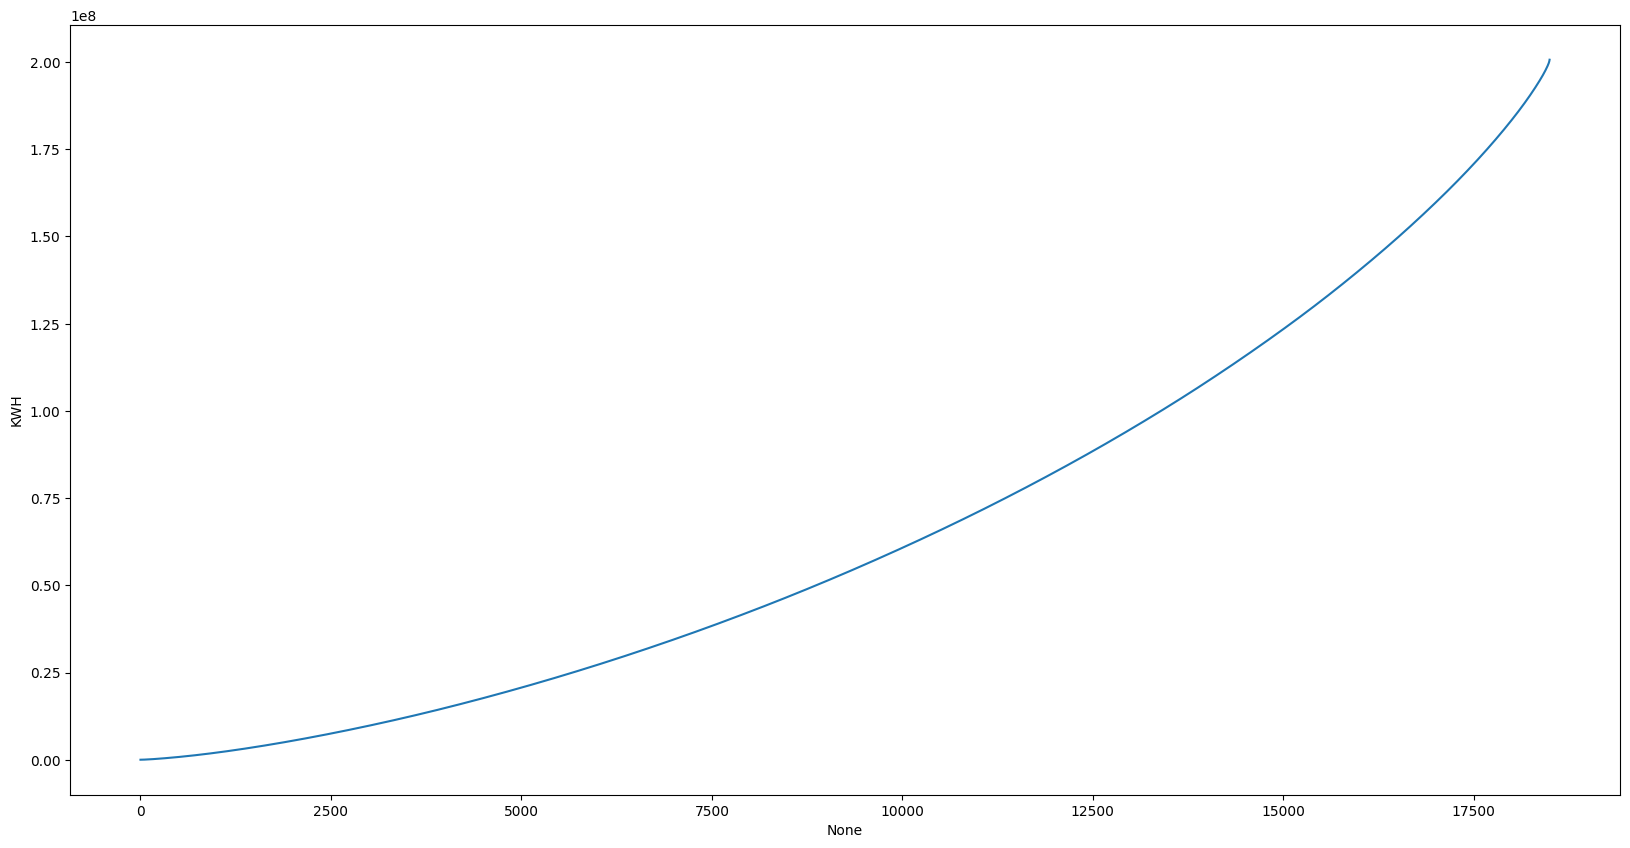

In [474]:
# Calculate percentiles
percentiles = np.arange(0, 100+10, 10)
percentile_values = df_raw["KWH"].quantile(q=[p/100 for p in percentiles])
print(percentile_values)

percentile_plot = percentile_values.cumsum()

# Calculate cumulative sum
kwh_cumsum = df_raw["KWH"].sort_values(ignore_index=True).cumsum()

# Plot the line graph
plt.figure(figsize=(20, 10))
sns.lineplot(x=kwh_cumsum.index, y=kwh_cumsum)

# Show the plot
plt.show()


<Axes: xlabel='KWH', ylabel='Count'>

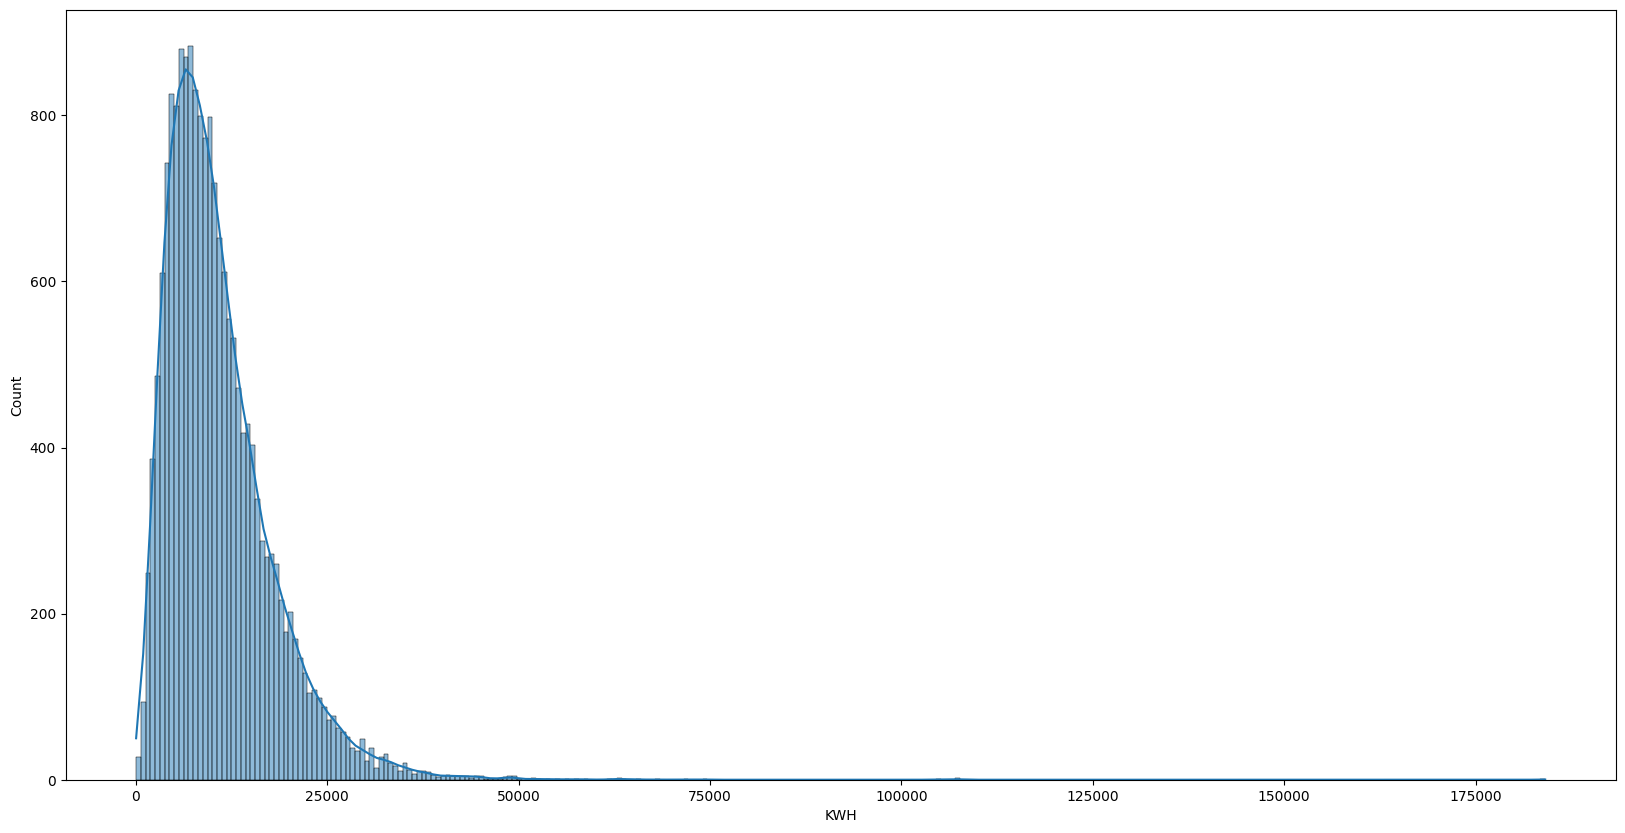

In [406]:
plt.figure(figsize=(20, 10))
sns.histplot(df_raw[original_columns].KWH, kde=True)


In [508]:
# Calculate the percentiles
percentile_min = df_raw['KWH'].quantile(0.1)
percentile_max = df_raw['KWH'].quantile(0.9)

# Filter the DataFrame based on the specified percentiles
filtered_df_raw = df_raw[(df['KWH'] >= percentile_min) & (df_raw['KWH'] <= percentile_max)]
filtered_df_raw


,DOEID,REGIONC,DIVISION,STATE_FIPS,state_postal,state_name,BA_climate,IECC_climate_code,UATYP10,HDD65,...,TOTALBTUWTH,TOTALDOLWTH,TOTALBTUOTH,TOTALDOLOTH,TOTALBTU,TOTALDOL,DBT1,DBT99,GWT,WOODTYPE
0,100001,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3844,...,21241.34,146.26,35017.07,1340.37,144647.71,2656.89,92.9,21.6,58.5,-2
1,100012,SOUTH,West South Central,48,TX,Texas,Hot-Dry,3B,U,2148,...,8774.40,93.57,21735.81,723.29,73867.11,1572.92,98.5,27.5,66.4,-2
2,100019,SOUTH,West South Central,5,AR,Arkansas,Mixed-Humid,3A,U,3078,...,6097.55,225.32,18507.20,683.89,51945.31,1635.06,93.0,23.3,61.9,-2
3,100036,SOUTH,West South Central,40,OK,Oklahoma,Mixed-Humid,3A,U,3137,...,3852.27,126.31,17746.70,475.64,70527.71,1394.84,98.6,18.8,59.5,-2
4,100053,SOUTH,South Atlantic,24,MD,Maryland,Mixed-Humid,4A,U,3776,...,3118.09,111.03,16136.91,519.31,59388.60,1328.63,91.3,17.9,56.7,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18490,118032,SOUTH,South Atlantic,12,FL,Florida,Hot-Humid,1A,U,100,...,11655.96,380.76,12929.27,422.35,33535.91,1095.50,90.6,51.6,79.8,-2
18491,118038,WEST,Mountain South,4,AZ,Arizona,Hot-Dry,2B,U,1179,...,10437.19,412.07,14965.80,590.87,47737.68,1884.75,106.4,38.7,70.9,-2
18492,118122,WEST,Pacific,6,CA,California,Hot-Dry,3B,U,1135,...,5893.03,269.91,11414.72,522.81,20111.13,921.11,83.7,45.7,64.9,-2
18493,118127,WEST,Pacific,15,HI,Hawaii,Hot-Humid,1A,U,0,...,6710.49,578.27,6323.81,544.95,14742.03,1270.38,89.9,61.8,77.4,-2


In [509]:
filtered_df_raw["KWH"].describe()


count    14796.000000
mean      9976.632696
std       4114.573693
min       3768.840000
25%       6581.267500
50%       9346.435000
75%      12866.882500
max      19802.040000
Name: KWH, dtype: float64

/var/folders/_c/nlmshnnn5g3d4z98zll3wrg00000gn/T/ipykernel_41879/3917863055.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  original_correlation_matrix = df_raw[original_columns].corr()
/var/folders/_c/nlmshnnn5g3d4z98zll3wrg00000gn/T/ipykernel_41879/3917863055.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_sorted_correlation.values, y=original_sorted_correlation.index, palette='viridis')


KWH              1.000000
SQFTEST          0.457875
TOTROOMS         0.402977
TVCOLOR          0.390913
NCOMBATH         0.379262
SWIMPOOL         0.375599
NUMFRIG          0.342159
TYPEHUQ          0.333803
WINDOWS          0.322728
NHSLDMEM         0.316398
SOLAR            0.302685
DRYER            0.259805
CWASHER          0.256428
STORIES          0.240493
LGTIN4TO8        0.209232
NUMLAPTOP        0.200452
LGTIN1TO4        0.197939
DISHWASH         0.184432
DESKTOP          0.181125
LGTINMORE8       0.172478
NHAFBATH         0.166012
AIRCOND          0.157057
MICRO            0.142306
YEARMADERANGE    0.129169
NUMPORTEL        0.069726
TELLWORK         0.066200
SMARTMETER       0.062203
HEATHOME         0.042573
ROOFTYPE         0.040503
EQUIPM           0.031546
WALLTYPE         0.007245
Name: KWH, dtype: float64


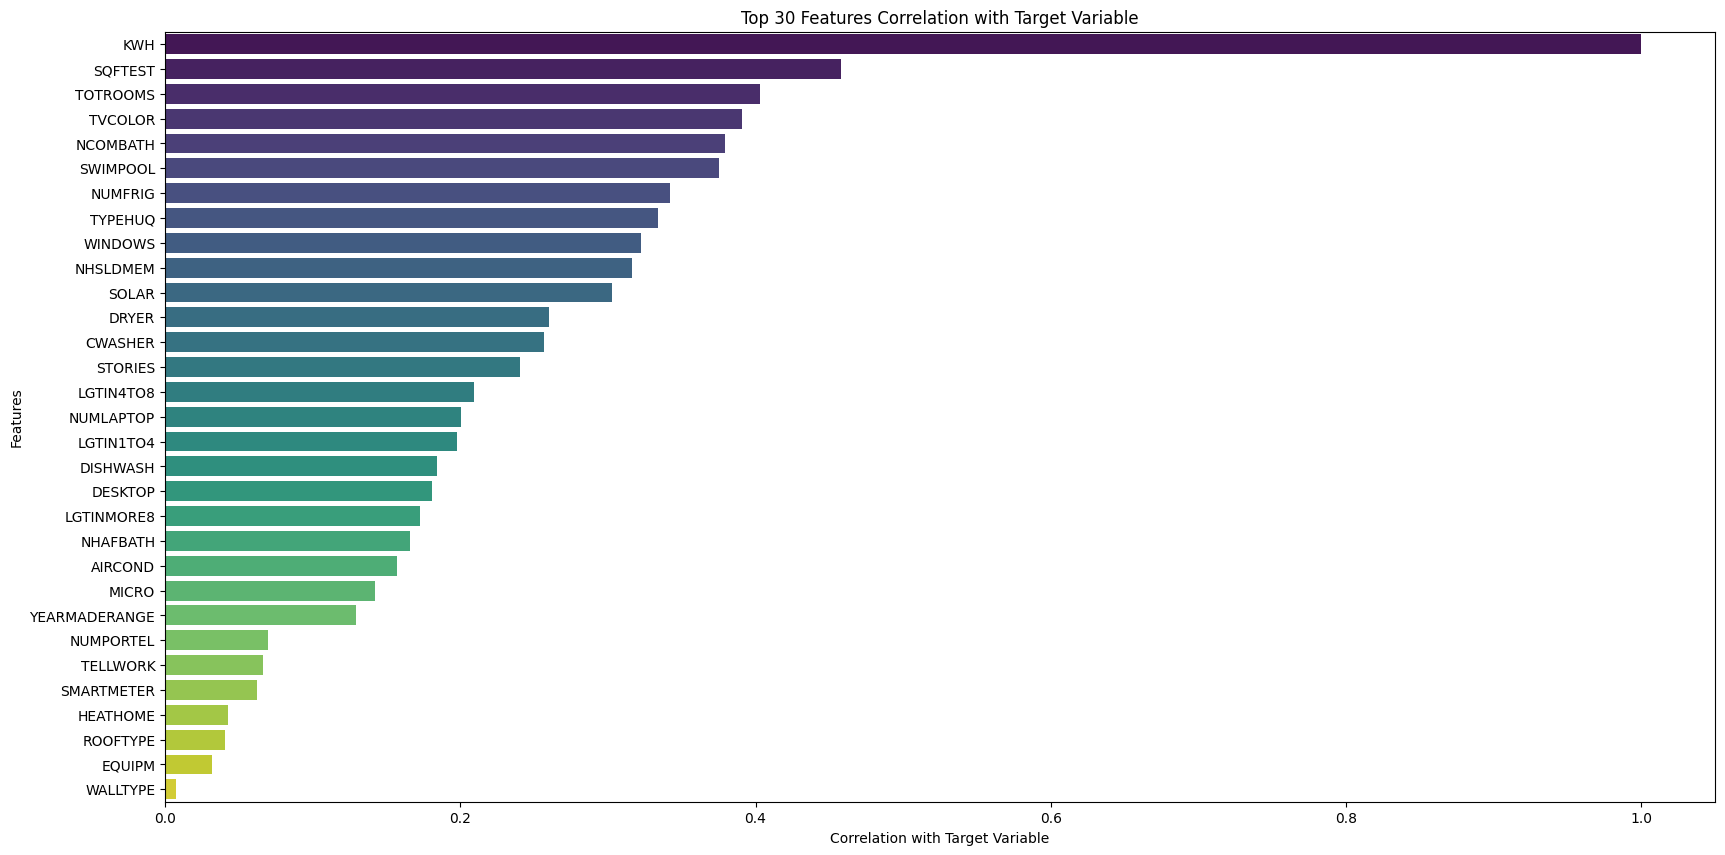

In [402]:
# Calculate correlation matrix
original_correlation_matrix = df_raw[original_columns].corr()

# Extract correlation values with the target variable
original_correlation_with_target = original_correlation_matrix['KWH']

# Sort correlation values in descending order
original_sorted_correlation = original_correlation_with_target.abs().sort_values(ascending=False)

# Display the results
print(original_sorted_correlation)

# Create a horizontal bar plot
plt.figure(figsize=(20, 10))
sns.barplot(x=original_sorted_correlation.values, y=original_sorted_correlation.index, palette='viridis')

# Add labels and title
plt.xlabel('Correlation with Target Variable')
plt.ylabel('Features')
plt.title('Top 30 Features Correlation with Target Variable')

# Show the plot
plt.show()


In [383]:
# Get the top 30 features and their names
top_30_features = sorted_correlation[1:31]

# top_30_features.index.values
# feature_mapping_description = feature_mapping.set_index('Variable')

feature_mapping[feature_mapping["Variable"].isin(top_30_features.index.values)]

# .index.isin(top_30_features.index.values)


,Variable,Type,Description and Labels,Response Codes,Section
13,TYPEHUQ,Num,Type of housing unit,1 Mobile home\n2 Single-family house detached ...,YOUR HOME
26,BEDROOMS,Num,Number of bedrooms (top-coded),0 - 6,YOUR HOME
27,NCOMBATH,Num,Number of full bathrooms (top-coded),0 - 4,YOUR HOME
29,OTHROOMS,Num,Number of other rooms (top-coded),1 - 9,YOUR HOME
30,TOTROOMS,Num,"Total number of rooms in the housing unit, exc...",1-15,YOUR HOME
31,STUDIO,Num,Studio apartment; a derived variable,1 Yes\n0 No\n-2 Not applicable,YOUR HOME
36,WINDOWS,Num,Number of windows,1 1 or 2 windows\n2 3 to 5 windows\n3 6 to 9 w...,YOUR HOME
44,SWIMPOOL,Num,Has swimming pool,1 Yes\n0 No\n-2 Not applicable,YOUR HOME
45,MONPOOL,Num,Months swimming pool used in the past year,0 - 12\n-2 Not applicable,YOUR HOME
46,POOLPUMP,Num,Has variable-speed pool pump,1 Yes\n0 No\n-2 Not applicable,YOUR HOME


/var/folders/_c/nlmshnnn5g3d4z98zll3wrg00000gn/T/ipykernel_41879/1350932822.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_30_features.values, y=top_30_features.index, palette='viridis')


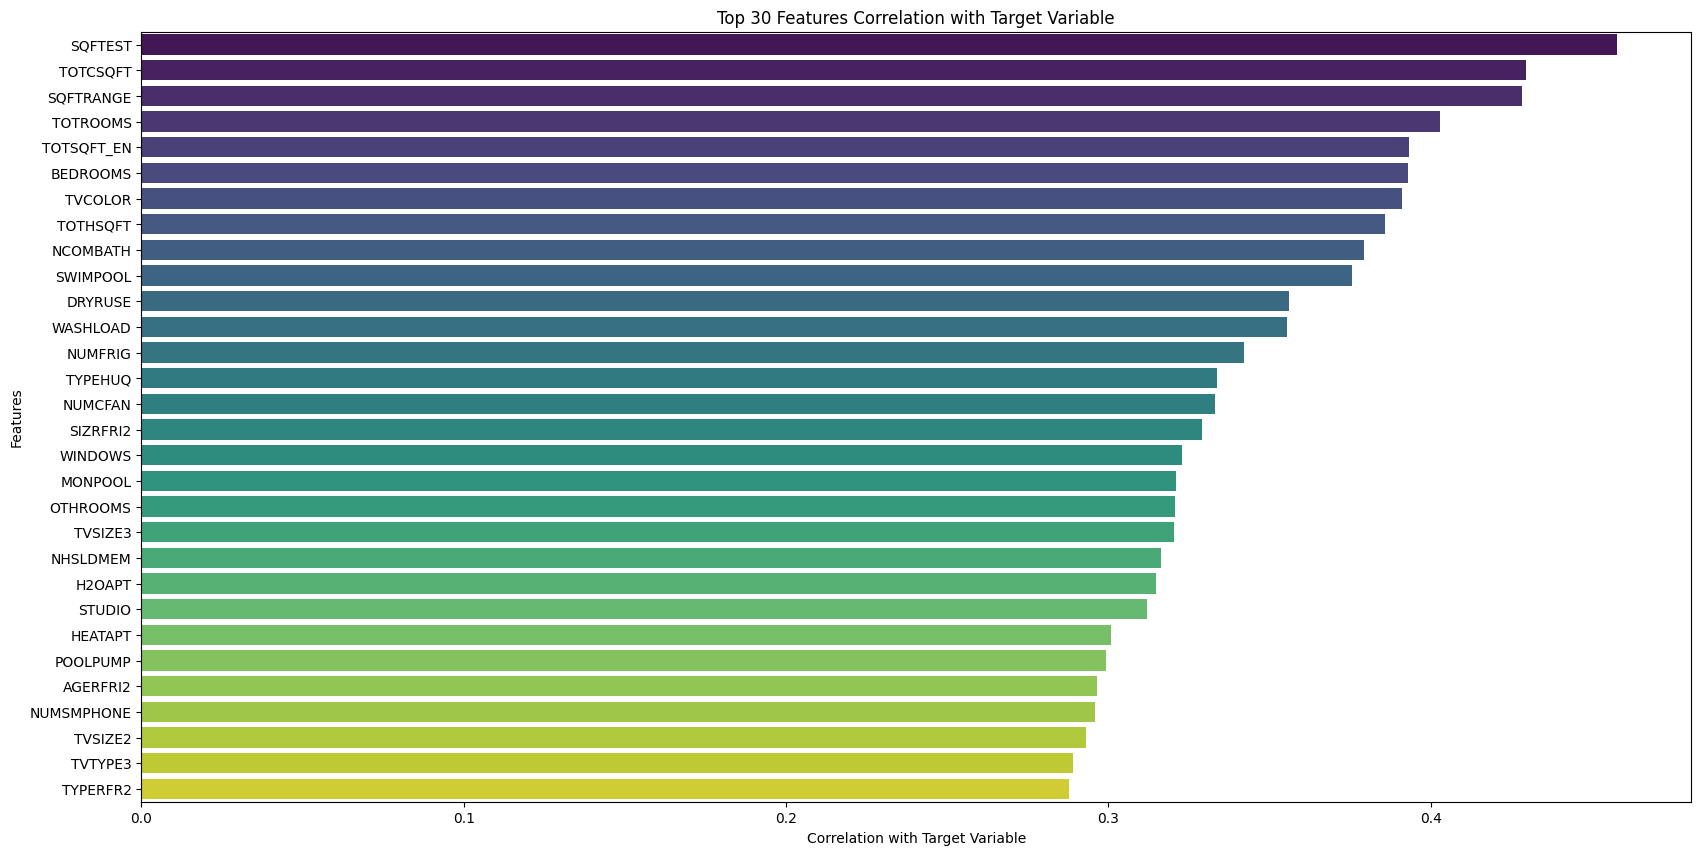

In [384]:
# Create a horizontal bar plot
plt.figure(figsize=(20, 10))
sns.barplot(x=top_30_features.values, y=top_30_features.index, palette='viridis')

# Add labels and title
plt.xlabel('Correlation with Target Variable')
plt.ylabel('Features')
plt.title('Top 30 Features Correlation with Target Variable')

# Show the plot
plt.show()


In [ ]:
correlation_with_target = correlation_matrix['KWH']


## Method 2 - Use Pre-Cleaned Data

In [208]:
df_clean = clean_data(df)
print(df_clean.shape)


(18496, 30)


In [209]:
df_clean.head()


,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,...,TELLWORK,HEATHOME,EQUIPM,AIRCOND,NHSLDMEM,SQFTEST,KWH,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
0,0.0,0.0,0.0,0.0,WEST,New Mexico,Mixed-Dry,Single_detached,1,70-79,...,0,1,Furnace,1,2,2100,12521.48,3,1,17
1,0.0,0.0,0.0,0.0,SOUTH,Texas,Hot-Dry,Single_detached,1,2010-15,...,0,1,Room_heater,1,5,3080,9657.64,3,3,11
2,0.0,0.0,0.0,0.0,SOUTH,Arkansas,Mixed-Humid,Single_attached,1,70-79,...,1,1,Furnace,1,3,990,9972.38,1,2,21
3,0.0,0.0,0.0,0.0,SOUTH,Oklahoma,Mixed-Humid,Single_detached,1,50-59,...,1,1,Furnace,1,2,1600,8167.71,2,4,19
4,0.0,1.0,0.0,0.0,SOUTH,Maryland,Mixed-Humid,Single_attached,2,Before_50,...,1,1,Furnace,1,2,1400,7159.45,4,3,45


In [210]:
X = df_clean.drop(columns="KWH")
y = df_clean.KWH


In [211]:
X.head()


,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,...,TVCOLOR,TELLWORK,HEATHOME,EQUIPM,AIRCOND,NHSLDMEM,SQFTEST,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
0,0.0,0.0,0.0,0.0,WEST,New Mexico,Mixed-Dry,Single_detached,1,70-79,...,3,0,1,Furnace,1,2,2100,3,1,17
1,0.0,0.0,0.0,0.0,SOUTH,Texas,Hot-Dry,Single_detached,1,2010-15,...,5,0,1,Room_heater,1,5,3080,3,3,11
2,0.0,0.0,0.0,0.0,SOUTH,Arkansas,Mixed-Humid,Single_attached,1,70-79,...,3,1,1,Furnace,1,3,990,1,2,21
3,0.0,0.0,0.0,0.0,SOUTH,Oklahoma,Mixed-Humid,Single_detached,1,50-59,...,1,1,1,Furnace,1,2,1600,2,4,19
4,0.0,1.0,0.0,0.0,SOUTH,Maryland,Mixed-Humid,Single_attached,2,Before_50,...,4,1,1,Furnace,1,2,1400,4,3,45


## Import Baseline Model

In [16]:
# Specify the path to your pickle file
file_path = '/Users/richardkemp/code/dicanadu/01-household-energy/model_h5/baseline/baseline_20231129-122043.pkl'

directory_path = '/path/to/your/directory'

# Load the model from the file
with open(file_path, 'rb') as file:
    loaded_model = pickle.load(file)


In [17]:
# Specify the directory path
directory_path = '/Users/richardkemp/code/dicanadu/01-household-energy/model_h5/baseline'

# Use glob to get a list of files in the directory sorted by modification time
list_of_files = glob.glob(os.path.join(directory_path, '*'))
latest_file = max(list_of_files, key=os.path.getmtime)

# Now you can use the 'latest_file' variable as your dynamic file path
print(f"The most recent file is: {latest_file}")

# Example usage, such as reading the contents of the file
# with open(latest_file, 'r') as file:
#     file_contents = file.read()
#     print("File contents:")
#     print(file_contents)

with open(latest_file, 'rb') as file:
    loaded_model = pickle.load(file)

baseline_model = loaded_model


The most recent file is: /Users/richardkemp/code/dicanadu/01-household-energy/model_h5/baseline/baseline_20231129-122043.pkl


## Transform X

In [499]:
# X.to_csv('/Users/richardkemp/code/dicanadu/01-household-energy/x_transform.csv', index=False)

# # /Users/richardkemp/code/dicanadu/01-household-energy/test.py
X_Challenger = filtered_df_raw[original_columns]

X_Challenger_float = X_Challenger.select_dtypes(include="float64")
cols_to_modify = X_Challenger_float.columns.values

for col in cols_to_modify:
    X_Challenger[col] = np.where(X_Challenger_float[col] < 0, np.nan, X_Challenger_float[col])

X_Challenger


/var/folders/_c/nlmshnnn5g3d4z98zll3wrg00000gn/T/ipykernel_41879/2826872792.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Challenger[col] = np.where(X_Challenger_float[col] < 0, np.nan, X_Challenger_float[col])


,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,NCOMBATH,NHAFBATH,TOTROOMS,WALLTYPE,...,NUMPORTEL,AIRCOND,LGTIN1TO4,LGTIN4TO8,LGTINMORE8,SMARTMETER,SOLAR,NHSLDMEM,SQFTEST,KWH
0,WEST,New Mexico,Mixed-Dry,2,1,4,3,0,8,1,...,-2,1,6,8,3,0,0,2,2100,12521.48
1,SOUTH,Texas,Hot-Dry,2,1,8,3,0,9,2,...,-2,1,4,5,2,0,0,5,3080,9657.64
2,SOUTH,Arkansas,Mixed-Humid,3,1,4,1,0,4,6,...,-2,1,3,15,3,-4,0,3,990,9972.38
3,SOUTH,Oklahoma,Mixed-Humid,2,1,2,2,0,7,1,...,-2,1,8,5,6,-4,0,2,1600,8167.71
4,SOUTH,Maryland,Mixed-Humid,3,2,1,3,1,5,1,...,1,1,23,10,12,-4,0,2,1400,7159.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18490,SOUTH,Florida,Hot-Humid,4,-2,9,1,0,4,1,...,-2,1,2,2,2,0,-2,4,700,9828.81
18491,WEST,Arizona,Hot-Dry,5,-2,7,2,0,5,4,...,-2,1,0,0,2,-4,-2,1,1200,13991.12
18492,WEST,California,Hot-Dry,5,-2,5,1,1,6,2,...,-2,1,2,2,1,-4,-2,3,790,5894.24
18493,WEST,Hawaii,Hot-Humid,5,-2,4,1,0,2,2,...,-2,0,0,2,0,-4,-2,1,600,4320.64


In [212]:
X_int_cols = ['SWIMPOOL','NUMPORTEL','SOLAR','SMARTMETER','STORIES','TOTROOMS','WINDOWS','NUMFRIG','MICRO','DISHWASH','CWASHER','DRYER','TVCOLOR','TELLWORK','HEATHOME','AIRCOND','NHSLDMEM','SQFTEST','TOTAL_BATH','TOTAL_COMP','TOTAL_LIGHT']

for col in X_int_cols:
    X[col] = X[col].astype(int)


In [213]:
X.dtypes


SWIMPOOL          int64
NUMPORTEL         int64
SOLAR             int64
SMARTMETER        int64
REGIONC          object
state_name       object
BA_climate       object
TYPEHUQ          object
STORIES           int64
YEARMADERANGE    object
TOTROOMS          int64
WALLTYPE         object
ROOFTYPE         object
WINDOWS           int64
NUMFRIG           int64
MICRO             int64
DISHWASH          int64
CWASHER           int64
DRYER             int64
TVCOLOR           int64
TELLWORK          int64
HEATHOME          int64
EQUIPM           object
AIRCOND           int64
NHSLDMEM          int64
SQFTEST           int64
TOTAL_BATH        int64
TOTAL_COMP        int64
TOTAL_LIGHT       int64
dtype: object

In [219]:
X_numeric = X.select_dtypes(include=["int","float"])
X_numeric


,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,STORIES,TOTROOMS,WINDOWS,NUMFRIG,MICRO,DISHWASH,...,DRYER,TVCOLOR,TELLWORK,HEATHOME,AIRCOND,NHSLDMEM,SQFTEST,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
0,0,0,0,0,1,8,4,2,1,1,...,1,3,0,1,1,2,2100,3,1,17
1,0,0,0,0,1,9,4,1,1,1,...,1,5,0,1,1,5,3080,3,3,11
2,0,0,0,0,1,4,2,1,1,1,...,1,3,1,1,1,3,990,1,2,21
3,0,0,0,0,1,7,4,1,1,1,...,1,1,1,1,1,2,1600,2,4,19
4,0,1,0,0,2,5,4,1,1,1,...,1,4,1,1,1,2,1400,4,3,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0,0,0,0,1,5,1,1,1,1,...,1,1,1,0,1,1,1200,2,2,2
18492,0,0,0,0,1,6,2,1,1,1,...,0,1,0,0,1,3,790,2,2,5
18493,0,0,0,0,1,2,2,1,1,0,...,0,2,0,0,0,1,600,1,0,2
18494,0,0,0,0,1,5,3,1,1,1,...,0,0,0,0,1,7,1010,2,3,1


In [220]:
X_object = X.select_dtypes(exclude=["int","float"])
X_object


,REGIONC,state_name,BA_climate,TYPEHUQ,YEARMADERANGE,WALLTYPE,ROOFTYPE,EQUIPM
0,WEST,New Mexico,Mixed-Dry,Single_detached,70-79,Brick,Shingle,Furnace
1,SOUTH,Texas,Hot-Dry,Single_detached,2010-15,Wood,Wood,Room_heater
2,SOUTH,Arkansas,Mixed-Humid,Single_attached,70-79,Stone,Shingle,Furnace
3,SOUTH,Oklahoma,Mixed-Humid,Single_detached,50-59,Brick,Shingle,Furnace
4,SOUTH,Maryland,Mixed-Humid,Single_attached,Before_50,Brick,Shingle,Furnace
...,...,...,...,...,...,...,...,...
18491,WEST,Arizona,Hot-Dry,Appartment_big,00-09,Stucco,Other,Other
18492,WEST,California,Hot-Dry,Appartment_big,80-89,Wood,Other,Other
18493,WEST,Hawaii,Hot-Humid,Appartment_big,70-79,Wood,Other,Other
18494,WEST,California,Marine,Appartment_small,60-69,Stucco,Concrete,Other


## Import Data

In [530]:
# Calculate the percentiles
percentile_min = df_raw['KWH'].quantile(0.05)
percentile_max = df_raw['KWH'].quantile(0.95)

# Filter the DataFrame based on the specified percentiles
filtered_df_raw = df_raw[(df['KWH'] >= percentile_min) & (df_raw['KWH'] <= percentile_max)]
filtered_df_raw

original_columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS", "WALLTYPE", "ROOFTYPE", "WINDOWS",
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP",
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST",
          "KWH"]

raw_data = pd.read_csv("/Users/richardkemp/code/dicanadu/01-household-energy/raw_data/recs2020_public_v6_csv.csv")

raw_data[original_columns].describe()


,TYPEHUQ,STORIES,YEARMADERANGE,NCOMBATH,NHAFBATH,TOTROOMS,WALLTYPE,ROOFTYPE,WINDOWS,SWIMPOOL,...,NUMPORTEL,AIRCOND,LGTIN1TO4,LGTIN4TO8,LGTINMORE8,SMARTMETER,SOLAR,NHSLDMEM,SQFTEST,KWH
count,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,...,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000,18496.000000
mean,2.547145,0.743837,4.543469,1.813473,0.357375,6.531737,3.035683,4.713938,3.887651,-0.304066,...,-1.207234,0.874297,5.589208,3.826125,1.923821,-1.415009,-0.338397,2.460856,1724.221453,10848.818722
std,1.119777,1.701967,2.325302,0.757783,0.532062,2.361461,6.154286,10.440012,1.430872,0.850486,...,1.563898,0.331523,6.188657,4.661733,3.664666,2.236302,0.816661,1.370600,907.606312,7111.765122
min,1.000000,-2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-2.000000,1.000000,-2.000000,...,-2.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,-2.000000,1.000000,240.000000,42.010000
25%,2.000000,1.000000,3.000000,1.000000,0.000000,5.000000,2.000000,3.000000,3.000000,0.000000,...,-2.000000,1.000000,2.000000,1.000000,0.000000,-4.000000,0.000000,1.000000,1100.000000,5921.970000
50%,2.000000,1.000000,5.000000,2.000000,0.000000,6.000000,3.000000,5.000000,4.000000,0.000000,...,-2.000000,1.000000,4.000000,2.000000,0.000000,0.000000,0.000000,2.000000,1530.000000,9346.435000
75%,3.000000,2.000000,6.000000,2.000000,1.000000,8.000000,3.000000,5.000000,5.000000,0.000000,...,-2.000000,1.000000,7.000000,5.000000,2.000000,1.000000,0.000000,3.000000,2160.000000,14155.327500
max,5.000000,5.000000,9.000000,4.000000,2.000000,15.000000,99.000000,99.000000,7.000000,1.000000,...,9.000000,1.000000,90.000000,84.000000,99.000000,1.000000,1.000000,7.000000,15000.000000,184101.840000


In [221]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

def create_preproc_numerical():
    return make_pipeline(
        KNNImputer(),
        MinMaxScaler()
    )

def create_preproc_nominal():
    return make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

def create_preproc(X):
    """Create an (unfitted) sklearn preprocessing pipeline well suited for the Houses Kaggle Competition

    Args:
        X (pandas.DataFrame): Feature matrix
        percentile (float): Percentage of feature to keep after one hot encoding

    Returns:
        sklearn.pipeline.Pipeline: un-fitted preprocessor
    """

    preproc_numerical = create_preproc_numerical()
    feat_numerical = sorted(X.select_dtypes(
        include=["int64", "float64"]).columns)

    preproc_nominal = create_preproc_nominal()
    feat_nominal = sorted(X.select_dtypes(
        exclude=["int64", "float64"]).columns)

    feature_transformer = ColumnTransformer(
        [
        ("numerical_encoder", preproc_numerical, feat_numerical),
        ("nominal_encoder", preproc_nominal, feat_nominal)
        ],
        remainder="drop")

    # feature_selector = SelectPercentile(
    #     mutual_info_regression,
    #     percentile=percentile,  # keep the xx% most important features
    # )

    preproc = make_pipeline(
        feature_transformer
        # feature_selector
    )
    return preproc


In [531]:
original_columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS", "WALLTYPE", "ROOFTYPE", "WINDOWS",
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP",
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST",
          "KWH"]

# Calculate the percentiles
percentile_min = df_raw['KWH'].quantile(0.05)
percentile_max = df_raw['KWH'].quantile(0.95)

# Filter the DataFrame based on the specified percentiles
filtered_df_raw = df_raw[(df['KWH'] >= percentile_min) & (df_raw['KWH'] <= percentile_max)]
filtered_df_raw = filtered_df_raw[original_columns]

X_filtered = filtered_df_raw.drop(columns="KWH")
y_filtered = filtered_df_raw["KWH"]


In [532]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)


In [533]:
X_train.shape


(11652, 33)

In [534]:
y_train.shape


(11652,)

In [535]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="most_frequent"), X_train.select_dtypes(include='int64').columns),
        ('cat', OneHotEncoder(drop='first'), X_train.select_dtypes(exclude='int64').columns)
    ],
    remainder='passthrough'  # Include columns not transformed
)

# Apply the ColumnTransformer to the DataFrame
X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())


In [536]:
X_train_scaled


,num__TYPEHUQ,num__STORIES,num__YEARMADERANGE,num__NCOMBATH,num__NHAFBATH,num__TOTROOMS,num__WALLTYPE,num__ROOFTYPE,num__WINDOWS,num__SWIMPOOL,...,cat__state_name_West Virginia,cat__state_name_Wisconsin,cat__state_name_Wyoming,cat__BA_climate_Hot-Dry,cat__BA_climate_Hot-Humid,cat__BA_climate_Marine,cat__BA_climate_Mixed-Dry,cat__BA_climate_Mixed-Humid,cat__BA_climate_Subarctic,cat__BA_climate_Very-Cold
0,2.0,5.0,5.0,2.0,0.0,9.0,3.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,-2.0,3.0,1.0,0.0,3.0,1.0,-2.0,2.0,-2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,-2.0,1.0,1.0,0.0,4.0,1.0,-2.0,3.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,1.0,5.0,2.0,0.0,10.0,2.0,5.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,1.0,2.0,1.0,1.0,6.0,3.0,99.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11647,2.0,1.0,1.0,3.0,0.0,8.0,4.0,5.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11648,3.0,1.0,6.0,1.0,0.0,2.0,1.0,5.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11649,2.0,2.0,6.0,3.0,1.0,12.0,3.0,5.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11650,2.0,2.0,1.0,2.0,0.0,9.0,3.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [537]:
X_train.head()


,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,NCOMBATH,NHAFBATH,TOTROOMS,WALLTYPE,...,EQUIPM,NUMPORTEL,AIRCOND,LGTIN1TO4,LGTIN4TO8,LGTINMORE8,SMARTMETER,SOLAR,NHSLDMEM,SQFTEST
1034,MIDWEST,Minnesota,Cold,2,5,5,2,0,9,3,...,3,2,1,8,6,2,-4,0,7,2400
8348,WEST,Arizona,Hot-Dry,5,-2,3,1,0,3,1,...,3,-2,1,6,6,0,0,-2,1,700
8736,NORTHEAST,New York,Mixed-Humid,5,-2,1,1,0,4,1,...,2,-2,1,4,4,4,1,-2,2,900
9617,SOUTH,Arkansas,Mixed-Humid,2,1,5,2,0,10,2,...,3,-2,1,2,4,0,0,0,2,1800
467,WEST,Colorado,Cold,2,1,2,1,1,6,3,...,3,-2,1,1,1,1,-4,0,7,1370


In [538]:
X_train_scaled.shape


(11652, 90)

In [539]:
X_train_scaled


,num__TYPEHUQ,num__STORIES,num__YEARMADERANGE,num__NCOMBATH,num__NHAFBATH,num__TOTROOMS,num__WALLTYPE,num__ROOFTYPE,num__WINDOWS,num__SWIMPOOL,...,cat__state_name_West Virginia,cat__state_name_Wisconsin,cat__state_name_Wyoming,cat__BA_climate_Hot-Dry,cat__BA_climate_Hot-Humid,cat__BA_climate_Marine,cat__BA_climate_Mixed-Dry,cat__BA_climate_Mixed-Humid,cat__BA_climate_Subarctic,cat__BA_climate_Very-Cold
0,2.0,5.0,5.0,2.0,0.0,9.0,3.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,-2.0,3.0,1.0,0.0,3.0,1.0,-2.0,2.0,-2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,-2.0,1.0,1.0,0.0,4.0,1.0,-2.0,3.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,1.0,5.0,2.0,0.0,10.0,2.0,5.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,1.0,2.0,1.0,1.0,6.0,3.0,99.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11647,2.0,1.0,1.0,3.0,0.0,8.0,4.0,5.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11648,3.0,1.0,6.0,1.0,0.0,2.0,1.0,5.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11649,2.0,2.0,6.0,3.0,1.0,12.0,3.0,5.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11650,2.0,2.0,1.0,2.0,0.0,9.0,3.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Tensor Flow

### Setup Tensor Flow

In [527]:
def initialize_model(input_shape: tuple) -> Model:
    """
    Initialize the Neural Network with random weights
    """
    # reg = regularizers.l1_l2(l2=0.005)

    # model = Sequential()
    # model.add(layers.Input(shape=input_shape))
    # model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg))
    # model.add(layers.BatchNormalization(momentum=0.9))
    # model.add(layers.Dropout(rate=0.1))
    # model.add(layers.Dense(50, activation="relu"))
    # model.add(layers.BatchNormalization(momentum=0.9))  # use momentum=0 to only use statistic of the last seen minibatch in inference mode ("short memory"). Use 1 to average statistics of all seen batch during training histories.
    # model.add(layers.Dropout(rate=0.1))
    # model.add(layers.Dense(1, activation="linear"))

    model = Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    print("✅ Model initialized")

    return model


def compile_model(model: Model, learning_rate=0.0005) -> Model:
    """
    Compile the Neural Network
    """
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    print("✅ Model compiled")

    return model

def train_model(
        model: Model,
        X: np.ndarray,
        y: np.ndarray,
        batch_size=256,
        patience=2,
        validation_split=0.3
    ) -> Tuple[Model, dict]:
    """
    Fit the model and return a tuple (fitted_model, history)
    """
    print(Fore.BLUE + "\nTraining model..." + Style.RESET_ALL)

    es = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X,
        y,
        validation_split=validation_split,
        epochs=300,
        batch_size=batch_size,
        callbacks=[es],
        verbose=1
    )

    print(f"✅ Model trained on {len(X)} rows with min val MAE: {round(np.min(history.history['val_mae']), 2)}")

    return model, history


def evaluate_model(
        model: Model,
        X: np.ndarray,
        y: np.ndarray,
        batch_size=64
    ) -> Tuple[Model, dict]:
    """
    Evaluate trained model performance on the dataset
    """

    print(Fore.BLUE + f"\nEvaluating model on {len(X)} rows..." + Style.RESET_ALL)

    if model is None:
        print(f"\n❌ No model to evaluate")
        return None

    metrics = model.evaluate(
        x=X,
        y=y,
        batch_size=batch_size,
        verbose=0,
        # callbacks=None,
        return_dict=True
    )

    loss = metrics["loss"]
    mae = metrics["mae"]

    print(f"✅ Model evaluated, MAE: {round(mae, 2)}")

    return metrics


In [540]:
print(X_train_scaled.shape)
print(y_train.shape)


(11652, 90)
(11652,)


### Train

In [541]:
learning_rate=0.0005
batch_size = 10
patience = 2

X_train_scaled = np.asarray(X_train_scaled).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

model = initialize_model(input_shape=X_train_scaled.shape[1:])
model = compile_model(model, learning_rate=learning_rate)
model, history = train_model(
    model, X_train_scaled, y_train,
    patience=patience,
    batch_size=batch_size,
    validation_split=0.3
    )

val_mae = np.min(history.history['val_mae'])


✅ Model initialized
✅ Model compiled

Training model...
Epoch 1/300
816/816 [==============================] - 1s 606us/step - loss: 41434072.0000 - mae: 4917.3984 - val_loss: 29439574.0000 - val_mae: 4086.1787
Epoch 2/300
816/816 [==============================] - 0s 521us/step - loss: 29469144.0000 - mae: 4117.1777 - val_loss: 28790426.0000 - val_mae: 4037.6589
Epoch 3/300
816/816 [==============================] - 0s 557us/step - loss: 28698080.0000 - mae: 4064.7356 - val_loss: 27819430.0000 - val_mae: 3968.5784
Epoch 4/300
816/816 [==============================] - 0s 550us/step - loss: 27619060.0000 - mae: 3989.8982 - val_loss: 26526676.0000 - val_mae: 3881.8845
Epoch 5/300
816/816 [==============================] - 0s 518us/step - loss: 26263496.0000 - mae: 3903.6152 - val_loss: 24942172.0000 - val_mae: 3801.7856
Epoch 6/300
816/816 [==============================] - 0s 547us/step - loss: 24819816.0000 - mae: 3813.3989 - val_loss: 23425622.0000 - val_mae: 3699.4124
Epoch 7/300
81